In [1]:
import os
import pickle

import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn

from models.forward import ForwardDiffusion
from models.reverse import ReverseDiffusion

%load_ext autoreload
%autoreload 2

In [2]:
def transform_CHW(img):
    img -= img.min()
    img /= img.max()
    return img.permute(1, 2, 0)

In [3]:
device = torch.device('mps')

## Data

In [4]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 16

trucks = torch.load('trucks.pt').float() * 2 / 255 - 1
trucks_dl = DataLoader(trucks, batch_size=batch_size, shuffle=True)

## Diffusion Processes

In [7]:
T = 500

forward = ForwardDiffusion(
    noise_param=(0.0001, 0.004), 
    T=T, 
    schedule='linear', 
    device=device
)
forward.to(device)

reverse = ReverseDiffusion(
    forward_process=forward, 
    time_embedding_dim=32, 
    time_n=512, 
    device=device
)
reverse.to(device)

print(f'{sum(p.numel() for p in reverse.parameters() if p.requires_grad)} parameters')

598537 parameters


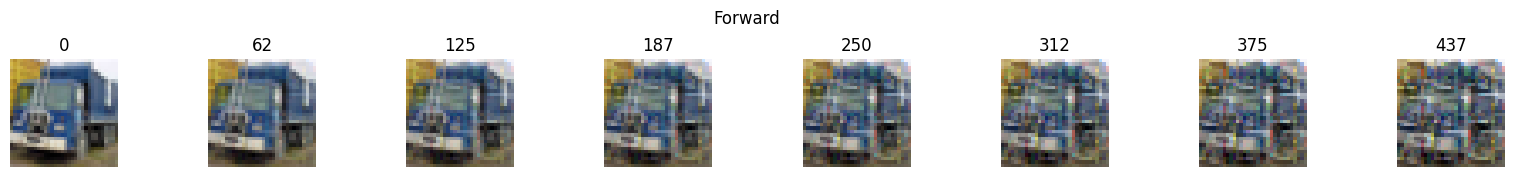

In [8]:
fig, axs = plt.subplots(1, 8, figsize=(16, 2))

fig.suptitle('Forward')
fig.tight_layout()

x = trucks[1].to(device)

for i in range(8):
    t = T * i // 8
    noised, eps = forward(x, t)
    axs[i].axis('off')
    axs[i].set_title(f'{t}')
    axs[i].imshow(transform_CHW(noised).cpu())

## Training

In [9]:
optimizer = torch.optim.Adam(reverse.parameters(), lr=0.0001)
L1Loss = nn.L1Loss()

for epoch in range(10):
    for x_0 in trucks_dl:
        x_0 = x_0.to(device)
        
        t = torch.randint(1, T+1, (x_0.shape[0], )).to(device)

        with torch.no_grad():
            x_t, eps = forward(x_0, t.view(16, 1, 1, 1))

        eps_hat = reverse.step(x_t, t)

        loss = L1Loss(eps, eps_hat)
        loss.backward()

        optimizer.step()
        
    print('.', end='')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 